In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
# !pip install pandas_datareader
import pandas_datareader.data as web

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
rawCovid = pd.read_csv("covid.csv")
variables = ["submission_date", "tot_cases", "new_case", "tot_death", "new_death"]
covid = rawCovid.loc[:,variables]

In [3]:
covid["submission_date"] = pd.to_datetime(covid["submission_date"])
covid.rename(columns={"submission_date":"Date"}, inplace=True)

In [4]:
weeklyCovid = covid.groupby(pd.Grouper(key = "Date", freq ="W")).sum()
weeklyCovid.reset_index(inplace=True)

weeklyCovid["case_change"] = weeklyCovid["tot_cases"].diff().fillna(0)/weeklyCovid["tot_cases"]
weeklyCovid["death_change"] = weeklyCovid["tot_death"].diff().fillna(0)/weeklyCovid["tot_death"]
weeklyCovid["death_change"].fillna(0, inplace=True)


In [5]:
bioStock = ["FBRX", "TRIL", "CODX", "ALIM", "BTAI"]
pharmStock = ["ABT", "RCUS", "LLY", "ELAN", "MRK"]
techStocks = ["BILI", "CCOI", "CHT"]
energyStocks = ["CVX","XOM","KMI","WMB","LNG"]
retailStocks = ["WMT","AMZN","COST","BIG","ACI"]
consumerStaplesStocks= ['VDC', 'VCSAX']
utilityStocks= [ 'VUIAX', 'VPU']
realEstateStocks = ['AMT', 'PLD', 'EQIX', 'BAM', 'ZG']
healthCareStocks = ['JNJ', 'MDT', 'NVS', 'PFE', 'GSK']
# please create lists of your stocks' ticker symbols


In [6]:
# please add your lists to tickerSymbol
tickerSymbol = bioStock + pharmStock + techStocks + energyStocks + retailStocks + consumerStaplesStocks + utilityStocks + realEstateStocks + healthCareStocks
# + "your lists"

In [7]:
start = "2020-01-22"
end = dt.now()

stocks = pd.DataFrame()
sc_df = pd.DataFrame()

for i in tickerSymbol:
    df = web.DataReader(i, "yahoo", start, end)
    df.reset_index(inplace=True)

    weeklyPrice = df.groupby([pd.Grouper(key="Date", freq="W")]).mean()
    weeklyPrice["Stock"] = i
    weeklyPrice.reset_index(inplace=True)
    
    stocks = stocks.append(weeklyPrice[["Adj Close", "Date", "Stock"]],
                          ignore_index = True)
    stocks["stock_price_change"] = stocks["Adj Close"].diff().fillna(0)
    
    sc_df = pd.merge(stocks, weeklyCovid, on="Date")

In [8]:
sc_df["Category"] = ""
sc_df.loc[sc_df["Stock"].isin(bioStock), "Category"] = "biotech"
sc_df.loc[sc_df["Stock"].isin(pharmStock), "Category"] = "pharmacy"
sc_df.loc[sc_df["Stock"].isin(techStocks), "Category"] = "it"
sc_df.loc[sc_df["Stock"].isin(energyStocks), "Category"] = "energy"
sc_df.loc[sc_df["Stock"].isin(retailStocks), "Category"] = "retail"
sc_df.loc[sc_df["Stock"].isin(consumerStaplesStocks), "Category"] = "consumer"
sc_df.loc[sc_df["Stock"].isin(utilityStocks), "Category"] = "utility"
sc_df.loc[sc_df["Stock"].isin(realEstateStocks), "Category"] = "realEstate"
sc_df.loc[sc_df["Stock"].isin(healthCareStocks), "Category"] = "healthcare"

# please add your stocks' categories


In [9]:
sc_df["Rise/Fall"] = ""
sc_df.loc[sc_df["stock_price_change"]>0, "Rise/Fall"] = "1"
sc_df.loc[sc_df["stock_price_change"]<0, "Rise/Fall"] = "-1"
sc_df.loc[sc_df["stock_price_change"]==0, "Rise/Fall"] = np.nan

sc_df.dropna(inplace=True)




In [10]:
sc_df

,Adj Close,Date,Stock,stock_price_change,tot_cases,new_case,tot_death,new_death,case_change,death_change,Category,Rise/Fall
1,3.996667,2020-01-26,TRIL,-30.923331,1,1.0,0,0.0,0.000000,0.000000,biotech,-1
2,1.680000,2020-01-26,CODX,-11.420000,1,1.0,0,0.0,0.000000,0.000000,biotech,-1
3,7.433333,2020-01-26,ALIM,-4.056666,1,1.0,0,0.0,0.000000,0.000000,biotech,-1
4,17.196667,2020-01-26,BTAI,12.996667,1,1.0,0,0.0,0.000000,0.000000,biotech,1
5,89.964806,2020-01-26,ABT,34.194805,1,1.0,0,0.0,0.000000,0.000000,pharmacy,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1527,139.719998,2020-11-08,JNJ,-0.236002,1161657,10032.0,25108,53.0,-5.808244,-5.920225,healthcare,-1
1528,103.117999,2020-11-08,MDT,-0.416000,1161657,10032.0,25108,53.0,-5.808244,-5.920225,healthcare,-1
1529,82.706001,2020-11-08,NVS,2.778001,1161657,10032.0,25108,53.0,-5.808244,-5.920225,healthcare,1
1530,36.284561,2020-11-08,PFE,0.342198,1161657,10032.0,25108,53.0,-5.808244,-5.920225,healthcare,1


In [11]:
## KNN 
# 
X = sc_df.drop(columns=['Adj Close','Date','Stock','stock_price_change','Category','Rise/Fall'],axis=1).values
y = sc_df['Rise/Fall'].values



#Splitting into test and train
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)


#Arrays to store data accuracy
neighbors = np.arange(1,9)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))


for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test) 


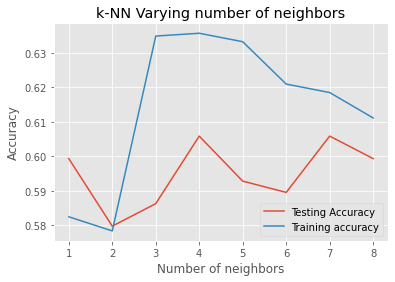

In [12]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [13]:
# Fitting the model with k=4
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
    
train_accuracy = knn.score(X_train, y_train)
test_accuracy = knn.score(X_test, y_test) 

#Accuracy:
test_accuracy

0.6058631921824105

In [14]:
#Confusion Matrix
y_pred = knn.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,-1,1,All
True,,,
-1,112,31,143
1,90,74,164
All,202,105,307


In [17]:
# Calculating Measures by hand
TP = 77
FP = 29
FN = 43
TN = 74
recall = TP/(TP+FN)
precision= TP/(TP+FP)
fmeasure = (2*recall*precision)/(recall+precision)
print("Recall: ",recall, "\nPrecision: ",precision, "\nF Measure: ", fmeasure)

Recall:  0.6416666666666667 
Precision:  0.7264150943396226 
F Measure:  0.6814159292035399


In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.55      0.78      0.65       143
           1       0.70      0.45      0.55       164

    accuracy                           0.61       307
   macro avg       0.63      0.62      0.60       307
weighted avg       0.63      0.61      0.60       307

